# Fever Medicine Recommendation Classifier — End-to-end notebook
**Filename:** `fever_medicine_classifier_notebook.ipynb`  
**Author / Team:** Ayushmitra (Pushkar Kumar & team)  
**Purpose:** Train and evaluate models to predict the recommended medication (Paracetamol or Ibuprofen) based on a patient's symptoms, medical history, lifestyle, and environmental factors.  
This notebook covers: EDA → preprocessing → train/validation/test split → model training (Logistic Regression, Random Forest, Keras NN) → evaluation → save artifacts to Google Drive → prediction helper for chatbot integration → upload to Hugging Face.  

**Notes**
- Place `enhanced_fever_medicine_recommendation.csv` inside:  
  `/content/drive/MyDrive/Ayushmitra_Models/fever_medicine_classifier/`  
- All artifacts (models, scaler, feature list, encoders, metadata) will be saved to the same Drive folder.
- This notebook is written to be copy-paste friendly for Google Colab.

In [1]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set project folder path (modify if needed)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier"
print("Model / data folder:", DRIVE_MODEL_DIR)

# Ensure folder exists and list files
import os
if os.path.exists(DRIVE_MODEL_DIR):
    print("Files in folder (first 50):")
    print(os.listdir(DRIVE_MODEL_DIR)[:50])
else:
    raise FileNotFoundError(f"Folder not found: {DRIVE_MODEL_DIR}. Create it and upload enhanced_fever_medicine_recommendation.csv there.")

Mounted at /content/drive
Model / data folder: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier
Files in folder (first 50):
['enhanced_fever_medicine_recommendation.csv', 'archive (2).zip', 'fever_medicine_classifier.ipynb']


## Install & Imports
We will import necessary libraries. Uncomment the pip installs if running in a fresh Colab environment.
- `tensorflow` for Keras neural network
- `scikit-learn` for classical ML and metrics
- `joblib` for saving scalers/encoders
- `huggingface_hub` for optional upload

In [2]:
# (Uncomment to install in a fresh runtime)
# !pip install -q tensorflow scikit-learn joblib seaborn matplotlib huggingface_hub

import pandas as pd
import numpy as np
import os, json, joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set(style="whitegrid")
print("Libraries imported.")

Libraries imported.


## Load dataset
Load `enhanced_fever_medicine_recommendation.csv` from the Drive folder. We'll inspect the first rows and basic shape.

In [3]:
DATA_CSV = os.path.join(DRIVE_MODEL_DIR, "enhanced_fever_medicine_recommendation.csv")

if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"Dataset not found: {DATA_CSV}. Upload the CSV to this folder.")

df = pd.read_csv(DATA_CSV)
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (1000, 20)


,Temperature,Fever_Severity,Age,Gender,BMI,Headache,Body_Ache,Fatigue,Chronic_Conditions,Allergies,Smoking_History,Alcohol_Consumption,Humidity,AQI,Physical_Activity,Diet_Type,Heart_Rate,Blood_Pressure,Previous_Medication,Recommended_Medication
0,36.1,Normal,89,Female,24.0,No,Yes,No,No,Yes,No,Yes,81.4,430,Moderate,Vegan,72,Normal,NaN,Ibuprofen
1,37.5,Mild Fever,94,Male,26.6,No,No,No,Yes,No,Yes,Yes,44.4,10,Active,Vegetarian,62,High,Ibuprofen,Paracetamol
2,36.4,Normal,92,Male,27.8,No,No,No,No,No,No,Yes,73.7,400,Sedentary,Vegan,85,High,NaN,Ibuprofen
3,39.8,High Fever,66,Male,18.7,No,Yes,No,No,No,No,No,44.1,438,Active,Non-Vegetarian,96,High,Ibuprofen,Ibuprofen
4,39.3,High Fever,28,Male,21.0,No,Yes,No,Yes,Yes,Yes,Yes,65.9,451,Active,Vegetarian,85,Low,Paracetamol,Ibuprofen


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['BMI'].plot(kind='hist', bins=20, title='BMI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Fever_Severity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Body_Ache').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Chronic_Conditions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='Temperature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Temperature', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='Age', y='BMI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='BMI', y='Humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Fever_Severity')):
  _plot_series(series, series_name, i)
  fig.legend(title='Fever_Severity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='Gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Body_Ache')):
  _plot_series(series, series_name, i)
  fig.legend(title='Body_Ache', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Chronic_Conditions')):
  _plot_series(series, series_name, i)
  fig.legend(title='Chronic_Conditions', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['BMI'].plot(kind='line', figsize=(8, 4), title='BMI')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Gender'].value_counts()
    for x_label, grp in _df_20.groupby('Fever_Severity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Fever_Severity')
_ = plt.ylabel('Gender')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Body_Ache'].value_counts()
    for x_label, grp in _df_21.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Body_Ache')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Chronic_Conditions'].value_counts()
    for x_label, grp in _df_22.groupby('Body_Ache')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Body_Ache')
_ = plt.ylabel('Chronic_Conditions')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Allergies'].value_counts()
    for x_label, grp in _df_23.groupby('Chronic_Conditions')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Chronic_Conditions')
_ = plt.ylabel('Allergies')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['Fever_Severity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='Fever_Severity', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['Body_Ache'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='Body_Ache', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['Chronic_Conditions'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='Chronic_Conditions', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Quick EDA (Exploratory Data Analysis)
We will:
- Inspect columns & datatypes
- Check missing values
- Check class distribution of the target variable
- Show basic statistics and simple histograms for numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature             1000 non-null   float64
 1   Fever_Severity          1000 non-null   object 
 2   Age                     1000 non-null   int64  
 3   Gender                  1000 non-null   object 
 4   BMI                     1000 non-null   float64
 5   Headache                1000 non-null   object 
 6   Body_Ache               1000 non-null   object 
 7   Fatigue                 1000 non-null   object 
 8   Chronic_Conditions      1000 non-null   object 
 9   Allergies               1000 non-null   object 
 10  Smoking_History         1000 non-null   object 
 11  Alcohol_Consumption     1000 non-null   object 
 12  Humidity                1000 non-null   float64
 13  AQI                     1000 non-null   int64  
 14  Physical_Activity       1000 non-null   o

None


Missing values per column:
Temperature                 0
Fever_Severity              0
Age                         0
Gender                      0
BMI                         0
Headache                    0
Body_Ache                   0
Fatigue                     0
Chronic_Conditions          0
Allergies                   0
Smoking_History             0
Alcohol_Consumption         0
Humidity                    0
AQI                         0
Physical_Activity           0
Diet_Type                   0
Heart_Rate                  0
Blood_Pressure              0
Previous_Medication       237
Recommended_Medication      0
dtype: int64

Columns: ['Temperature', 'Fever_Severity', 'Age', 'Gender', 'BMI', 'Headache', 'Body_Ache', 'Fatigue', 'Chronic_Conditions', 'Allergies', 'Smoking_History', 'Alcohol_Consumption', 'Humidity', 'AQI', 'Physical_Activity', 'Diet_Type', 'Heart_Rate', 'Blood_Pressure', 'Previous_Medication', 'Recommended_Medication']

Target column: Recommended_Medication
Recom

,Temperature,Age,BMI,Humidity,AQI,Heart_Rate
count,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,38.09890,51.152000,26.44320,60.594400,248.493000,80.14400
std,1.13887,28.873354,4.90115,17.058475,143.705244,11.79196
min,36.00000,1.000000,18.00000,30.000000,0.000000,60.00000
25%,37.20000,26.000000,22.40000,46.600000,127.750000,70.00000
50%,38.20000,51.000000,26.50000,60.950000,247.500000,80.00000
75%,39.10000,76.000000,30.52500,74.725000,375.250000,90.00000
max,40.00000,100.000000,35.00000,90.000000,499.000000,100.00000


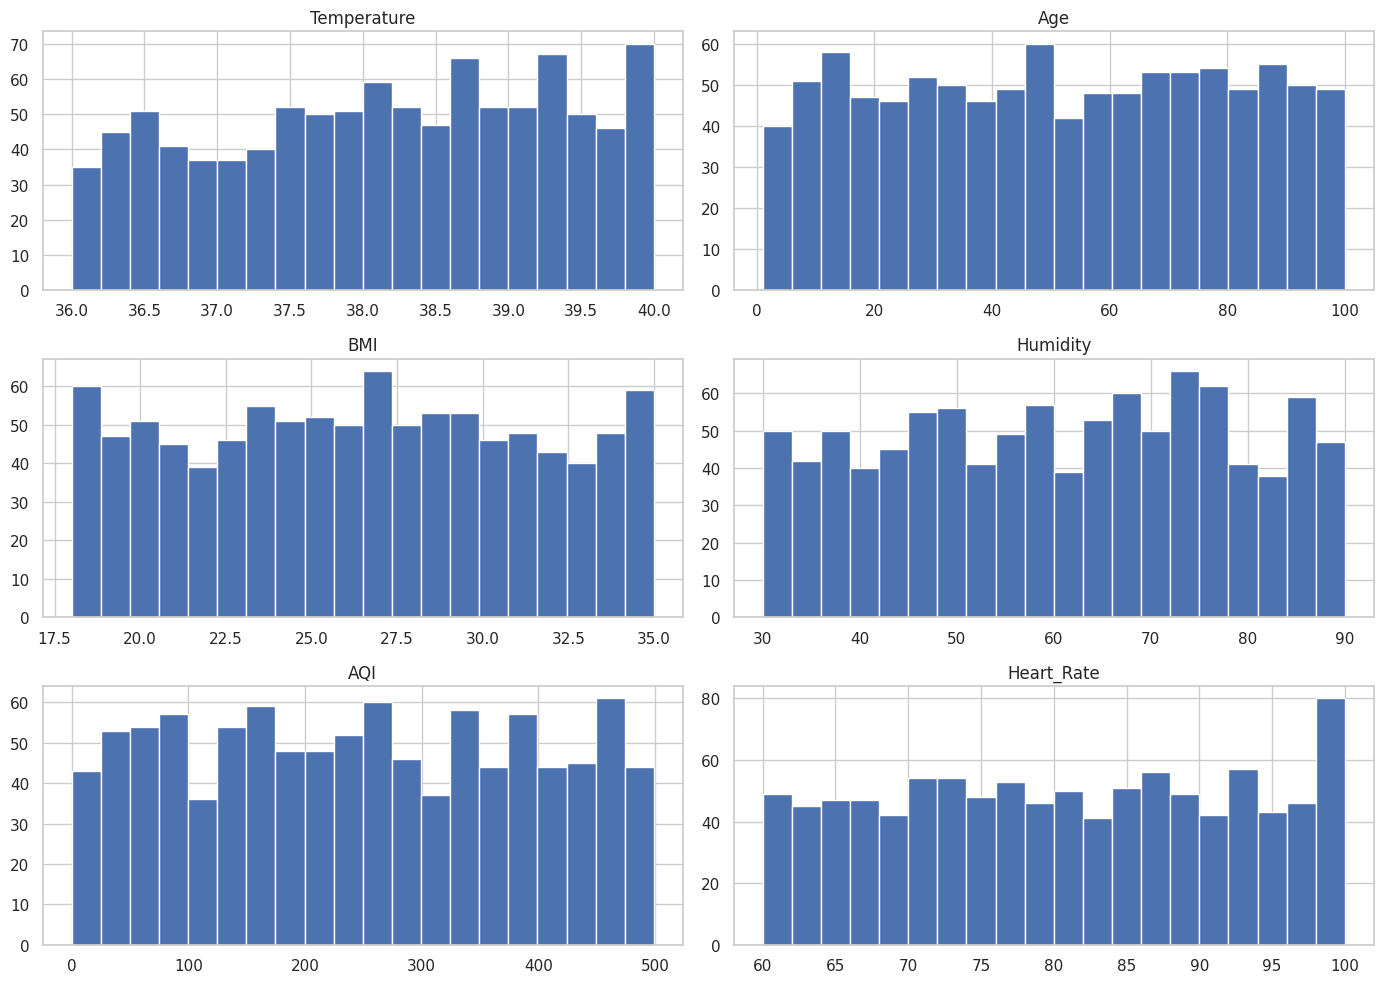

from matplotlib import pyplot as plt
_df_28['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['BMI'].plot(kind='hist', bins=20, title='BMI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['Humidity'].plot(kind='hist', bins=20, title='Humidity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_32.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33.plot(kind='scatter', x='Temperature', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='Age', y='BMI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='BMI', y='Humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='Humidity', y='AQI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_38['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_39['BMI'].plot(kind='line', figsize=(8, 4), title='BMI')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_40['Humidity'].plot(kind='line', figsize=(8, 4), title='Humidity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_41['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_41, x='Temperature', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_42['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_42, x='Age', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_43['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_43, x='BMI', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_44['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_44, x='Humidity', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [4]:
# Normalize column names (strip spaces, make consistent)
df.columns = [c.strip() for c in df.columns]

# Info & missing values
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# Show column list
print("\nColumns:", df.columns.tolist())

# Target column is 'Recommended_Medication'
target_col = 'Recommended_Medication'
print(f"\nTarget column: {target_col}")
print(df[target_col].value_counts(dropna=False))

# Numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
display(df[numeric_cols].describe())

# Histograms for numeric features
if numeric_cols:
    df[numeric_cols].hist(bins=20, figsize=(14, 10))
    plt.tight_layout()
    plt.show()

## Decide prediction task & target mapping
We'll predict the `Recommended_Medication` (Paracetamol or Ibuprofen). This is a binary classification task. We will map the text labels to integers using `LabelEncoder`.

In [5]:
# The target is categorical, we will encode it.
le_target = LabelEncoder()
y = le_target.fit_transform(df[target_col])

print("Detected classes and integer mapping:")
class_map = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(class_map)

print("\nTarget distribution (counts):")
print(pd.Series(y).value_counts().sort_index())

# Save label encoder for the target variable
target_encoder_path = os.path.join(DRIVE_MODEL_DIR, "target_label_encoder.pkl")
joblib.dump(le_target, target_encoder_path)
print("Saved target label encoder to:", target_encoder_path)

Detected classes and integer mapping:
{'Ibuprofen': np.int64(0), 'Paracetamol': np.int64(1)}

Target distribution (counts):
0    801
1    199
Name: count, dtype: int64
Saved target label encoder to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/target_label_encoder.pkl


## Feature selection & preprocessing plan
- **Features**: Use all columns except the target.
- **Encode Categorical Features**: Many features are categorical (`Fever_Severity`, `Gender`, `Headache`, etc.). We will use `LabelEncoder` for each.
- **Fill Missing Values**: The dataset appears clean, but we'll add a step to fill with median/mode just in case.
- **Scale Numeric Features**: Use `StandardScaler` on numerical columns like `Temperature`, `Age`, `BMI`.
- **Split**: Train (70%), Validation (15%), Test (15%) stratified by the target.
- **Models**: Logistic Regression, Random Forest, Keras NN.

In [6]:
# Features are all columns except the target
X = df.drop(columns=[target_col])

# Encode all categorical features
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
feature_encoders = {}
print("Categorical columns to encode:", cat_cols)

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    feature_encoders[col] = le

# Save the dictionary of feature encoders
feature_encoders_path = os.path.join(DRIVE_MODEL_DIR, "feature_encoders.pkl")
joblib.dump(feature_encoders, feature_encoders_path)
print(f"Saved {len(feature_encoders)} feature encoders to: {feature_encoders_path}")

# Final feature list
feature_list = X.columns.tolist()
print("\nFinal feature list (used for modelling):", feature_list)

# Quick sanity check
display(X.head())

Categorical columns to encode: ['Fever_Severity', 'Gender', 'Headache', 'Body_Ache', 'Fatigue', 'Chronic_Conditions', 'Allergies', 'Smoking_History', 'Alcohol_Consumption', 'Physical_Activity', 'Diet_Type', 'Blood_Pressure', 'Previous_Medication']
Saved 13 feature encoders to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/feature_encoders.pkl

Final feature list (used for modelling): ['Temperature', 'Fever_Severity', 'Age', 'Gender', 'BMI', 'Headache', 'Body_Ache', 'Fatigue', 'Chronic_Conditions', 'Allergies', 'Smoking_History', 'Alcohol_Consumption', 'Humidity', 'AQI', 'Physical_Activity', 'Diet_Type', 'Heart_Rate', 'Blood_Pressure', 'Previous_Medication']


,Temperature,Fever_Severity,Age,Gender,BMI,Headache,Body_Ache,Fatigue,Chronic_Conditions,Allergies,Smoking_History,Alcohol_Consumption,Humidity,AQI,Physical_Activity,Diet_Type,Heart_Rate,Blood_Pressure,Previous_Medication
0,36.1,2,89,0,24.0,0,1,0,0,1,0,1,81.4,430,1,1,72,2,3
1,37.5,1,94,1,26.6,0,0,0,1,0,1,1,44.4,10,0,2,62,0,1
2,36.4,2,92,1,27.8,0,0,0,0,0,0,1,73.7,400,2,1,85,0,3
3,39.8,0,66,1,18.7,0,1,0,0,0,0,0,44.1,438,0,0,96,0,1
4,39.3,0,28,1,21.0,0,1,0,1,1,1,1,65.9,451,0,2,85,1,2


## Train / Validation / Test split
We split data into:
- Train: 70%
- Validation: 15%
- Test: 15%
We stratify by target to preserve class balance.

In [7]:
# Stratified split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# Split temp into val & test (each 15% overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Identify numeric columns for scaling
numeric_cols_to_scale = X.select_dtypes(include=np.number).columns.tolist()

# Scale numeric features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_val_scaled = scaler.transform(X_val[numeric_cols_to_scale])
X_test_scaled = scaler.transform(X_test[numeric_cols_to_scale])

# Save scaler and feature list for later inference
scaler_path = os.path.join(DRIVE_MODEL_DIR, "scaler_fever_med.pkl")
joblib.dump(scaler, scaler_path)
feat_file = os.path.join(DRIVE_MODEL_DIR, "feature_list_fever_med.json")
with open(feat_file, "w") as f:
    json.dump(feature_list, f)
print("Saved scaler to:", scaler_path)
print("Saved feature list to:", feat_file)

Sizes -> Train: (700, 19) Val: (150, 19) Test: (150, 19)
Saved scaler to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/scaler_fever_med.pkl
Saved feature list to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/feature_list_fever_med.json


## Baseline model: Logistic Regression
Train a logistic regression baseline. We'll evaluate on the validation set.

In [8]:
# Logistic regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

# Validate
y_val_pred_lr = lr.predict(X_val_scaled)
print("Validation classification report (Logistic Regression):\n")
print(classification_report(y_val, y_val_pred_lr, target_names=le_target.classes_))

Validation classification report (Logistic Regression):

              precision    recall  f1-score   support

   Ibuprofen       0.88      0.62      0.73       120
 Paracetamol       0.30      0.67      0.42        30

    accuracy                           0.63       150
   macro avg       0.59      0.64      0.57       150
weighted avg       0.77      0.63      0.66       150



## Ensemble baseline: Random Forest
Train a RandomForestClassifier and inspect validation performance and feature importances.

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Validation
y_val_pred_rf = rf.predict(X_val_scaled)
print("Validation classification report (Random Forest):\n")
print(classification_report(y_val, y_val_pred_rf, target_names=le_target.classes_))

# Feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_list).sort_values(ascending=False)
print("\nTop feature importances:\n", feat_imp.head(10))

# Save RF model
rf_path = os.path.join(DRIVE_MODEL_DIR, "rf_fever_med.pkl")
joblib.dump(rf, rf_path)
print("Saved Random Forest to:", rf_path)

Validation classification report (Random Forest):

              precision    recall  f1-score   support

   Ibuprofen       1.00      1.00      1.00       120
 Paracetamol       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


Top feature importances:
 Temperature            0.459910
Fever_Severity         0.397282
BMI                    0.023484
AQI                    0.021066
Age                    0.020012
Humidity               0.019570
Heart_Rate             0.016057
Blood_Pressure         0.005842
Previous_Medication    0.005798
Body_Ache              0.005564
dtype: float64
Saved Random Forest to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/rf_fever_med.pkl


## Neural network (Keras)
A small dense NN with dropout and EarlyStopping for binary classification. We will save the best model to Drive.

In [10]:
# Build NN
tf.random.set_seed(42)
nn_version = "v1"
input_dim = X_train_scaled.shape[1]

nn = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks: EarlyStopping + ModelCheckpoint
nn_model_file = os.path.join(DRIVE_MODEL_DIR, f"nn_fever_med_{nn_version}.h5")
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint(nn_model_file, monitor='val_loss', save_best_only=True)

# Train
history = nn.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                 epochs=100, batch_size=32, callbacks=[es, mc], verbose=2)

print("Best NN model saved to:", nn_model_file)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 - 3s - 139ms/step - accuracy: 0.4957 - loss: 0.7265 - val_accuracy: 0.7600 - val_loss: 0.5859
Epoch 2/100


22/22 - 0s - 13ms/step - accuracy: 0.7714 - loss: 0.5601 - val_accuracy: 0.8000 - val_loss: 0.5070
Epoch 3/100


22/22 - 0s - 9ms/step - accuracy: 0.8014 - loss: 0.5188 - val_accuracy: 0.8000 - val_loss: 0.4839
Epoch 4/100


22/22 - 0s - 8ms/step - accuracy: 0.8014 - loss: 0.5077 - val_accuracy: 0.8000 - val_loss: 0.4703
Epoch 5/100


22/22 - 0s - 8ms/step - accuracy: 0.8000 - loss: 0.4840 - val_accuracy: 0.8000 - val_loss: 0.4570
Epoch 6/100


22/22 - 0s - 13ms/step - accuracy: 0.8029 - loss: 0.4546 - val_accuracy: 0.8000 - val_loss: 0.4442
Epoch 7/100


22/22 - 0s - 8ms/step - accuracy: 0.8029 - loss: 0.4531 - val_accuracy: 0.8000 - val_loss: 0.4322
Epoch 8/100


22/22 - 0s - 13ms/step - accuracy: 0.7971 - loss: 0.4255 - val_accuracy: 0.8000 - val_loss: 0.4162
Epoch 9/100


22/22 - 0s - 15ms/step - accuracy: 0.7986 - loss: 0.4143 - val_accuracy: 0.8000 - val_loss: 0.3988
Epoch 10/100


22/22 - 0s - 8ms/step - accuracy: 0.8071 - loss: 0.3885 - val_accuracy: 0.8000 - val_loss: 0.3791
Epoch 11/100


22/22 - 0s - 13ms/step - accuracy: 0.8014 - loss: 0.3746 - val_accuracy: 0.8000 - val_loss: 0.3557
Epoch 12/100


22/22 - 0s - 8ms/step - accuracy: 0.8129 - loss: 0.3456 - val_accuracy: 0.8000 - val_loss: 0.3312
Epoch 13/100


22/22 - 0s - 8ms/step - accuracy: 0.8143 - loss: 0.3289 - val_accuracy: 0.8000 - val_loss: 0.3065
Epoch 14/100


22/22 - 0s - 14ms/step - accuracy: 0.8300 - loss: 0.2945 - val_accuracy: 0.8133 - val_loss: 0.2811
Epoch 15/100


22/22 - 0s - 14ms/step - accuracy: 0.8557 - loss: 0.2762 - val_accuracy: 0.8333 - val_loss: 0.2542
Epoch 16/100


22/22 - 0s - 17ms/step - accuracy: 0.8729 - loss: 0.2467 - val_accuracy: 0.8533 - val_loss: 0.2309
Epoch 17/100


22/22 - 0s - 14ms/step - accuracy: 0.8871 - loss: 0.2237 - val_accuracy: 0.8667 - val_loss: 0.2070
Epoch 18/100


22/22 - 0s - 12ms/step - accuracy: 0.9171 - loss: 0.2035 - val_accuracy: 0.8800 - val_loss: 0.1842
Epoch 19/100


22/22 - 0s - 12ms/step - accuracy: 0.9214 - loss: 0.1863 - val_accuracy: 0.9400 - val_loss: 0.1590
Epoch 20/100


22/22 - 0s - 10ms/step - accuracy: 0.9429 - loss: 0.1636 - val_accuracy: 0.9467 - val_loss: 0.1409
Epoch 21/100


22/22 - 0s - 11ms/step - accuracy: 0.9471 - loss: 0.1504 - val_accuracy: 0.9600 - val_loss: 0.1248
Epoch 22/100


22/22 - 0s - 14ms/step - accuracy: 0.9571 - loss: 0.1348 - val_accuracy: 0.9800 - val_loss: 0.1057
Epoch 23/100


22/22 - 0s - 13ms/step - accuracy: 0.9786 - loss: 0.1036 - val_accuracy: 0.9933 - val_loss: 0.0884
Epoch 24/100


22/22 - 0s - 15ms/step - accuracy: 0.9800 - loss: 0.0940 - val_accuracy: 0.9867 - val_loss: 0.0830
Epoch 25/100


22/22 - 1s - 28ms/step - accuracy: 0.9800 - loss: 0.0902 - val_accuracy: 0.9933 - val_loss: 0.0664
Epoch 26/100


22/22 - 0s - 11ms/step - accuracy: 0.9900 - loss: 0.0742 - val_accuracy: 0.9933 - val_loss: 0.0583
Epoch 27/100


22/22 - 0s - 8ms/step - accuracy: 0.9871 - loss: 0.0734 - val_accuracy: 0.9933 - val_loss: 0.0537
Epoch 28/100


22/22 - 0s - 15ms/step - accuracy: 0.9857 - loss: 0.0658 - val_accuracy: 0.9933 - val_loss: 0.0502
Epoch 29/100


22/22 - 0s - 12ms/step - accuracy: 0.9857 - loss: 0.0656 - val_accuracy: 0.9933 - val_loss: 0.0447
Epoch 30/100


22/22 - 0s - 8ms/step - accuracy: 0.9857 - loss: 0.0565 - val_accuracy: 0.9933 - val_loss: 0.0384
Epoch 31/100


22/22 - 0s - 7ms/step - accuracy: 0.9943 - loss: 0.0423 - val_accuracy: 0.9933 - val_loss: 0.0350
Epoch 32/100


22/22 - 0s - 9ms/step - accuracy: 0.9943 - loss: 0.0367 - val_accuracy: 0.9933 - val_loss: 0.0276
Epoch 33/100


22/22 - 0s - 13ms/step - accuracy: 0.9943 - loss: 0.0331 - val_accuracy: 0.9933 - val_loss: 0.0241
Epoch 34/100
22/22 - 0s - 12ms/step - accuracy: 0.9957 - loss: 0.0317 - val_accuracy: 0.9933 - val_loss: 0.0241
Epoch 35/100
22/22 - 0s - 6ms/step - accuracy: 0.9914 - loss: 0.0343 - val_accuracy: 0.9933 - val_loss: 0.0259
Epoch 36/100


22/22 - 0s - 8ms/step - accuracy: 0.9929 - loss: 0.0328 - val_accuracy: 0.9933 - val_loss: 0.0233
Epoch 37/100


22/22 - 0s - 14ms/step - accuracy: 0.9943 - loss: 0.0299 - val_accuracy: 0.9933 - val_loss: 0.0200
Epoch 38/100


22/22 - 0s - 14ms/step - accuracy: 0.9957 - loss: 0.0251 - val_accuracy: 0.9933 - val_loss: 0.0154
Epoch 39/100
22/22 - 0s - 6ms/step - accuracy: 0.9957 - loss: 0.0203 - val_accuracy: 0.9933 - val_loss: 0.0162
Epoch 40/100
22/22 - 0s - 6ms/step - accuracy: 0.9957 - loss: 0.0229 - val_accuracy: 0.9933 - val_loss: 0.0163
Epoch 41/100
22/22 - 0s - 6ms/step - accuracy: 0.9957 - loss: 0.0246 - val_accuracy: 0.9933 - val_loss: 0.0175
Epoch 42/100


22/22 - 0s - 9ms/step - accuracy: 0.9986 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 43/100


22/22 - 0s - 9ms/step - accuracy: 0.9986 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 44/100


22/22 - 0s - 18ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 45/100
22/22 - 0s - 20ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 46/100


22/22 - 0s - 17ms/step - accuracy: 0.9957 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0102
Epoch 47/100


22/22 - 1s - 28ms/step - accuracy: 0.9986 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 48/100


22/22 - 1s - 27ms/step - accuracy: 0.9986 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 49/100
22/22 - 1s - 26ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 50/100
22/22 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 51/100
22/22 - 0s - 6ms/step - accuracy: 0.9971 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 52/100
22/22 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 53/100


22/22 - 0s - 15ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 54/100


22/22 - 0s - 13ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 55/100
22/22 - 0s - 11ms/step - accuracy: 0.9986 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 56/100
22/22 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 57/100


22/22 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 58/100


22/22 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 59/100


22/22 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 60/100


22/22 - 0s - 8ms/step - accuracy: 0.9971 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 61/100
22/22 - 0s - 6ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 62/100
22/22 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 63/100
22/22 - 0s - 6ms/step - accuracy: 0.9929 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 64/100
22/22 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 65/100
22/22 - 0s - 7ms/step - accuracy: 0.9986 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 66/100
22/22 - 0s - 6ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 67/100
22/22 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 68/100
22/22 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0041
Best NN model

## Training curves for the neural network
We will plot training & validation loss and accuracy to check for overfitting.

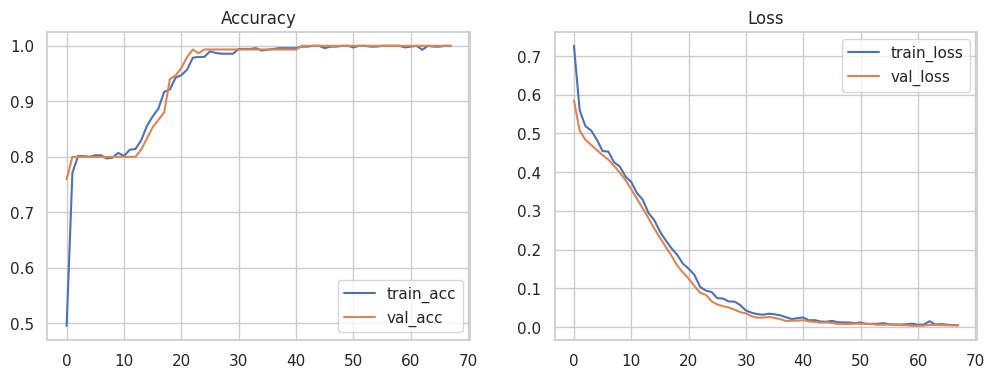

In [11]:
# Plot accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

## Evaluate all selected models on the TEST set
We will evaluate Logistic Regression, Random Forest, and the best Neural Network on the reserved test set.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

=== Logistic Regression ===
Accuracy: 0.6866666666666666
Precision: 0.373134328358209
Recall: 0.8333333333333334
F1: 0.5154639175257731
ROC AUC: 0.7250000000000001

Classification report:
              precision    recall  f1-score   support

   Ibuprofen       0.94      0.65      0.77       120
 Paracetamol       0.37      0.83      0.52        30

    accuracy                           0.69       150
   macro avg       0.66      0.74      0.64       150
weighted avg       0.83      0.69      0.72       150



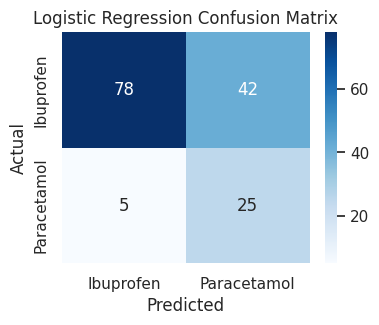


=== Random Forest ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0

Classification report:
              precision    recall  f1-score   support

   Ibuprofen       1.00      1.00      1.00       120
 Paracetamol       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



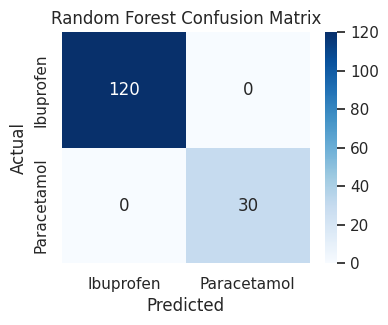


=== Neural Network ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0

Classification report:
              precision    recall  f1-score   support

   Ibuprofen       1.00      1.00      1.00       120
 Paracetamol       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



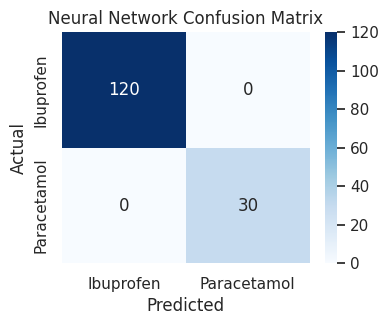

In [12]:
# Logistic Regression
y_test_pred_lr = lr.predict(X_test_scaled)
y_test_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Random Forest
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Neural Net - load best saved model and predict
nn_loaded = tf.keras.models.load_model(nn_model_file)
y_test_proba_nn = nn_loaded.predict(X_test_scaled).ravel()
y_test_pred_nn = (y_test_proba_nn >= 0.5).astype(int)

# Utility to print metrics & plot confusion matrix
def print_metrics(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    except Exception as e:
        print("ROC AUC: N/A", e)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=le_target.classes_, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(model_name + " Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# Print metrics
print_metrics(y_test, y_test_pred_lr, y_test_proba_lr, "Logistic Regression")
print_metrics(y_test, y_test_pred_rf, y_test_proba_rf, "Random Forest")
print_metrics(y_test, y_test_pred_nn, y_test_proba_nn, "Neural Network")

## Save model artifacts and metadata for integration
We will save:
- The final models (lr, rf, nn)
- Scaler (already saved)
- Feature list (saved)
- Feature encoders and target encoder (saved earlier)
- `metadata.json` describing model versions and input format
All saved inside `DRIVE_MODEL_DIR`.

In [13]:
# Save logistic regression model
lr_path = os.path.join(DRIVE_MODEL_DIR, "lr_fever_med.pkl")
joblib.dump(lr, lr_path)
print("Saved Logistic Regression to:", lr_path)

# RF saved earlier to rf_path; NN saved to nn_model_file; encoders and scaler saved.

# Create and save metadata
metadata = {
    "model_name": "fever_medicine_classifier",
    "models": {
        "logistic_regression": os.path.basename(lr_path),
        "random_forest": os.path.basename(rf_path),
        "neural_network": os.path.basename(nn_model_file)
    },
    "features": feature_list,
    "target_column": target_col,
    "target_label_encoder": os.path.basename(target_encoder_path),
    "feature_encoders": os.path.basename(feature_encoders_path),
    "scaler": os.path.basename(scaler_path),
    "notes": "Binary classifier for recommending Paracetamol or Ibuprofen based on patient data. For research/demo use only."
}

meta_file = os.path.join(DRIVE_MODEL_DIR, "metadata_fever_med.json")
with open(meta_file, "w") as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata to:", meta_file)

Saved Logistic Regression to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/lr_fever_med.pkl
Saved metadata to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/metadata_fever_med.json


## Prediction helper for chatbot/backend
A reusable function that:
- Accepts a dict of raw inputs (feature_name -> value).
- Encodes categorical features and scales numeric features correctly.
- Applies the chosen model.
- Returns probability, predicted label, and human-friendly text.

In [14]:
# Load all artifacts for inference
scaler = joblib.load(scaler_path)
rf_model = joblib.load(rf_path)
lr_model = joblib.load(lr_path)
nn_model = tf.keras.models.load_model(nn_model_file)
with open(feat_file, "r") as f:
    feature_list = json.load(f)
feature_encoders = joblib.load(feature_encoders_path)
target_encoder = joblib.load(target_encoder_path)

def prepare_input(raw_input: dict):
    # Create a DataFrame with the correct column order
    df_row = pd.DataFrame([raw_input], columns=feature_list)

    # Encode categorical features
    for col, encoder in feature_encoders.items():
        # Handle unseen labels by assigning a default value (e.g., -1 or a new category)
        try:
            df_row[col] = encoder.transform(df_row[col].astype(str))
        except ValueError:
            # If a category was not seen during training, map to -1 or handle appropriately
            df_row[col] = -1

    # Scale numeric features
    numeric_cols = df_row.select_dtypes(include=np.number).columns.tolist()
    df_row[numeric_cols] = scaler.transform(df_row[numeric_cols])

    return df_row.values

def predict_fever_med(raw_input: dict, model_type="rf"):
    arr = prepare_input(raw_input)
    if model_type == "rf":
        proba = float(rf_model.predict_proba(arr)[:,1][0])
    elif model_type == "lr":
        proba = float(lr_model.predict_proba(arr)[:,1][0])
    elif model_type == "nn":
        proba = float(nn_model.predict(arr).ravel()[0])
    else:
        raise ValueError("model_type must be one of ['rf','lr','nn']")

    label_idx = int(proba >= 0.5)
    pred_label = target_encoder.inverse_transform([label_idx])[0]

    return {"probability_of_class_1": proba, "prediction_index": label_idx, "prediction": pred_label}

# Test prediction with a dummy input
sample_input = {
    'Temperature': 38.5, 'Fever_Severity': 'High Fever', 'Age': 35, 'Gender': 'Male',
    'BMI': 22.5, 'Headache': 'Yes', 'Body_Ache': 'Yes', 'Fatigue': 'Yes',
    'Chronic_Conditions': 'No', 'Allergies': 'No', 'Smoking_History': 'No',
    'Alcohol_Consumption': 'No', 'Humidity': 60.0, 'AQI': 50,
    'Physical_Activity': 'Moderate', 'Diet_Type': 'Non-Vegetarian',
    'Heart_Rate': 85, 'Blood_Pressure': 'Normal', 'Previous_Medication': 'None'
}

print("RF prediction:", predict_fever_med(sample_input, "rf"))

RF prediction: {'probability_of_class_1': 0.005, 'prediction_index': 0, 'prediction': 'Ibuprofen'}


## FastAPI snippet — serve model as HTTP endpoint
Save this as `app.py` and deploy. The chatbot will call `/predict_fever_med`.

In [15]:
fastapi_snippet = f'''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, numpy as np, tensorflow as tf

app = FastAPI()

# Load all artifacts
SCALER_PATH = "{scaler_path}"
RF_PATH = "{rf_path}"
FEATURES_PATH = "{feat_file}"
FEATURE_ENCODERS_PATH = "{feature_encoders_path}"
TARGET_ENCODER_PATH = "{target_encoder_path}"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)
feature_encoders = joblib.load(FEATURE_ENCODERS_PATH)
target_encoder = joblib.load(TARGET_ENCODER_PATH)

class Query(BaseModel):
    data: dict

def prepare_input_row(raw_input):
    df_row = pd.DataFrame([raw_input], columns=features)
    for col, encoder in feature_encoders.items():
        try:
            df_row[col] = encoder.transform(df_row[col].astype(str))
        except ValueError:
            df_row[col] = -1
    numeric_cols = df_row.select_dtypes(include=np.number).columns
    df_row[numeric_cols] = scaler.transform(df_row[numeric_cols])
    return df_row.values

@app.post("/predict_fever_med")
def predict(query: Query):
    arr = prepare_input_row(query.data)
    proba = float(rf.predict_proba(arr)[:,1][0])
    label_idx = int(proba >= 0.5)
    pred_label = target_encoder.inverse_transform([label_idx])[0]
    return {{"probability_of_class_1": proba, "prediction": pred_label}}
'''
print(fastapi_snippet)


from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, numpy as np, tensorflow as tf

app = FastAPI()

# Load all artifacts
SCALER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/scaler_fever_med.pkl"
RF_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/rf_fever_med.pkl"
FEATURES_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/feature_list_fever_med.json"
FEATURE_ENCODERS_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/feature_encoders.pkl"
TARGET_ENCODER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_medicine_classifier/target_label_encoder.pkl"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)
feature_encoders = joblib.load(FEATURE_ENCODERS_PATH)
target_encoder = joblib.load(TARGET_ENCODER_PATH)

class Query(BaseMo

## Upload model artifacts to Hugging Face Hub (optional)
This reusable function pushes your saved artifacts (`.pkl`, `.h5`, `scaler`, README) into a HF model repo. You will need a Hugging Face token.

In [16]:
# Hugging Face upload helper
from huggingface_hub import HfApi, HfFolder, Repository
import shutil

def upload_to_hf(local_dir, repo_id, hf_token, commit_message="Initial model upload"):
    """
    local_dir: local directory containing model artifacts + README.md
    repo_id: "your-username/repo-name"
    hf_token: your huggingface token (string)
    """
    # Save token so Repository can use it
    HfFolder.save_token(hf_token)

    api = HfApi()
    try:
        api.create_repo(repo_id=repo_id, exist_ok=True, token=hf_token)
        print("Repo created/ready:", repo_id)
    except Exception as e:
        print("Repo create/exists (continuing):", e)

    # Use Repository to push (it will clone the remote)
    repo = Repository(local_dir, clone_from=repo_id, use_auth_token=hf_token)
    repo.push_to_hub(commit_message=commit_message)
    print("Uploaded to HF repo:", repo_id)

# Prepare local folder to upload
local_dir = "hf_fever_med_model"
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)
os.makedirs(local_dir, exist_ok=True)

# Copy all artifacts into the local directory
artifacts = [lr_path, rf_path, nn_model_file, scaler_path, feat_file, target_encoder_path, feature_encoders_path, meta_file]
for p in artifacts:
    if os.path.exists(p):
        shutil.copy(p, local_dir)

# Create a basic README for the repo
with open(os.path.join(local_dir, "README.md"), "w") as f:
    f.write("# Fever Medicine Recommendation Classifier\\n\\nModel artifacts for recommending Paracetamol or Ibuprofen.\\n")

print("Local HF folder prepared at:", local_dir)
print("When ready, call: upload_to_hf(local_dir, 'your-username/fever-med-classifier', hf_token='hf_xxx')")

Local HF folder prepared at: hf_fever_med_model
When ready, call: upload_to_hf(local_dir, 'your-username/fever-med-classifier', hf_token='hf_xxx')


## Integration notes for the chatbot
- **Endpoint**: `POST /predict_fever_med`
- **Payload**: `{ "data": {"Temperature": 38.5, "Fever_Severity": "High Fever", ...} }`
- **Response**: `{ "probability_of_class_1": 0.87, "prediction": "Ibuprofen" }`

**Best practices:**
- Always show a disclaimer that this is not medical advice.
- If probability is near 0.5, the bot should state the uncertainty and strongly recommend consulting a doctor.
- Log inputs and outputs (anonymized) to monitor performance and for future retraining.

## Next steps & model improvements
1. **One-Hot Encoding**: For non-ordinal categorical features like `Diet_Type` or `Previous_Medication`, One-Hot Encoding might perform better than Label Encoding.
2. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV to find the best parameters for the RandomForest or NN models.
3. **Explainability**: Integrate SHAP to explain why a particular medication was recommended, which is crucial for doctor trust.
4. **Expand Target**: Modify the model to be multi-class to include other medications like 'Aspirin' or 'None'.
5. **Clinical Validation**: Test the model's recommendations against a doctor's advice in a controlled, non-production environment.

### Final notes & reproducibility
- Keep `enhanced_fever_medicine_recommendation.csv` and all saved artifacts (`.pkl`, `.h5`, `.json`) together in your `DRIVE_MODEL_DIR`.
- The `upload_to_hf` helper function is reusable for all your other model notebooks.
- This notebook provides a complete and reproducible pipeline for the Fever Medicine Recommendation model, a key component of the Ayushmitra project.